In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

N_STATES = 5
GAMMA = 1
START = int((N_STATES + 1) / 2)
END_STATES = [0, N_STATES + 1]

TRUE_V = np.arange(N_STATES + 2)/ (N_STATES + 1)
TRUE_V[END_STATES[0]] = TRUE_V[END_STATES[-1]] = 0
print("TURE Values:{}".format(TRUE_V))
V = np.ones(N_STATES + 2) * 0.5
V[END_STATES[0]] = V[END_STATES[-1]] = 0
print("Initial Values:{}".format(V))

LEFT = 0
RIGHT = 1

TURE Values:[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 0.        ]
Initial Values:[0.  0.5 0.5 0.5 0.5 0.5 0. ]


In [2]:
def td_n_step(V, n, alpha=0.1):
    state = START
    states = [state]
    rewards = [0]
    time = 0
    T = float('inf')
    while True:
        if time < T:
            if np.random.binomial(1, 0.5) == LEFT:
                next_state = state - 1
            else:
                next_state = state + 1
            if next_state == END_STATES[-1]:
                reward = 1
            else:
                reward = 0 
            if next_state in END_STATES:
                T = time + 1
            
            # 存储新状态和新奖励值
            states.append(next_state)
            rewards.append(reward)
            
        update_time = time - n + 1
        if update_time >= 0:
            g = 0.0
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                g += pow(GAMMA, t - update_time - 1) * rewards[t]
            if update_time + n < T:
                g += pow(GAMMA, n) * V[states[update_time + n]]
            update_state = states[update_time]
            if not update_state in END_STATES:
                V[update_state] += alpha * (g - V[update_state])
        if update_time == T - 1:
            break
        time += 1
        state = next_state

In [3]:
def RMS(curr_V):
    return np.sqrt(np.sum(np.power(TRUE_V - curr_V, 2)) / N_STATES)

In [5]:
def plot_n_steps():
    steps = np.power(2, np.arange(0, 10))
    alphas = np.arange(0, 1.1, 0.1)
    episodes = 10
    N = 100 # 重复实验的次数
    errors = np.zeros((len(steps), len(alphas)))
    for n in range(N):
        for step_ind, step in enumerate(steps):
            for alpha_ind, alpha in enumerate(alphas):
                curr_V = V.copy()
                for ep in range(episodes):
                    td_n_step(curr_V, step, alpha)
                    errors[step_ind, alpha_ind] += RMS(curr_V)
    errors /= episodes * N
    for i in range(len(steps)):
        plt.plot(alphas, errors[i], label='n={}'.format(steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.1, 0.236])
    plt.legend()
    return errors


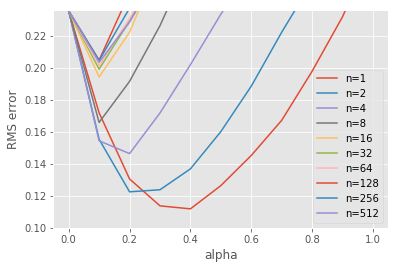

In [6]:
n_step_errors = plot_n_steps()

In [8]:
def td_lambda(V, lam, alpha=0.1):
    E = np.zeros((N_STATES + 2))
    state = START
    while True:
        if np.random.binomial(1, 0.5) == LEFT:
            next_state = state - 1
        else:
            next_state = state + 1
        if next_state == END_STATES[-1]:
            reward = 1
        else:
            reward = 0
        E = E * GAMMA * lam
        E[state] += 1
        td_error = reward + GAMMA * V[next_state] - V[state]
        V += alpha * td_error * E
        if next_state in END_STATES:
            break
        state = next_state

In [9]:
def plot_lambdas():
    lambdas = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.975,0.99])
    alphas = np.arange(0, 1.1, 0.1)
    episodes = 10
    N = 100 # 重复实验的次数
    errors = np.zeros((len(lambdas), len(alphas)))
    for n in range(N):
        for lam_ind, lam in enumerate(lambdas):
            for alpha_ind, alpha in enumerate(alphas):
                curr_V = V.copy()
                for ep in range(episodes):
                    td_lambda(curr_V, lam, alpha)
                    errors[lam_ind, alpha_ind] += RMS(curr_V)
    errors /= episodes * N
    for i in range(len(lambdas)):
        plt.plot(alphas, errors[i], label='lambda={}'.format(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.1, 0.236])
    plt.legend()
    return errors

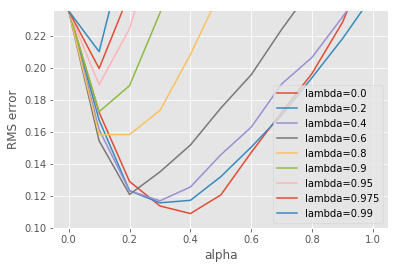

In [10]:
lambda_errors = plot_lambdas()

In [11]:
def choose_action_by_epsilon_greedy(state, Q, epsilon):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.binomial(1, 0.5)
    else:
        values = Q[state]
        return np.random.choice([a for a, v in enumerate(values) if v == np.max(values)])

In [12]:
def sarsa_lambda(Q, epsilon=0.1, alpha=0.5, lam=0.4):
    state = START
    action = choose_action_by_epsilon_greedy(state, Q, epsilon)
    E = np.zeros((N_STATES + 2, 2))
    while True:
        if action == LEFT:
            next_state = state - 1
        else:
            next_state = state + 1
        if next_state == END_STATES[-1]:
            reward = 1
        else:
            reward = 0
        E[state, action] += 1
        next_a =  choose_action_by_epsilon_greedy(next_state, Q, epsilon)
        td_error = reward + GAMMA * Q[next_state, next_a] -  Q[state, action]
        Q += alpha * td_error * E
        E = GAMMA * lam * E
        if next_state in END_STATES:
            break
        state = next_state
        action = next_a



In [13]:
def optimize_with_sarsa_lambda(max_time_step):
    Q = np.zeros((N_STATES + 2, 2))
    for _ in range(max_time_step):
        sarsa_lambda(Q)
    return Q



In [14]:
Q = optimize_with_sarsa_lambda(1000)
print('Optimal Q: {}'.format(Q))

Optimal Q: [[0.         0.        ]
 [0.         0.97551518]
 [0.93186558 0.99999823]
 [0.99996023 1.        ]
 [0.99999888 1.        ]
 [1.         1.        ]
 [0.         0.        ]]


In [15]:
from IPython.display import Latex
from IPython.display import display

def plot_sarsa_policy(Q):
    policy_str = '$'
    for s in range(1, N_STATES + 1):
        if np.argmax(Q[s]) == RIGHT:
            policy_str += r'\rightarrow'
        else:
            policy_str += r'\leftarrow'
    policy_str += '$'
    display(Latex(policy_str))

In [16]:
plot_sarsa_policy(Q)



<IPython.core.display.Latex object>